In [1]:
# pip install pandas
# pip install matplotlib

# pip install librosa
# pip install scipy

In [2]:
import os
import datetime

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

import subprocess

import librosa
import scipy
from scipy import stats
from scipy.io import wavfile

### input file
- rejestratory dzwieku na androidzie Samsung s21, którego uzywam w aplikacji dyktafon zapisują nagranie w formacie m4a, 
- inne telefony moga zapisywać również w mp3 czy wav, 
- wydaje mi się, że analiza powinna się zaczynac od pliku wav, czyli zuatomatyzowany pipeline powinien w pierwszym kroku, przkształcać do jednego formatu wpadające pliki

### Konwrcja pliku na wav
Udało się konvertować przy pomocy ffmpeg,  plik wyjsciowy wav jest 5 x cięższy od m4a
   - Pobieranie FFmpeg
        Przejdź na stronę https://www.gyan.dev/ffmpeg/builds/
        Pobierz paczkę "git-full" dla twojej architektury (najprawdopodobniej 64-bit). Paczka powinna być w formacie .7z.

   - Wypakowanie FFmpeg
        Musisz wypakować pobrany plik .7z. Jeżeli nie masz narzędzia do obsługi tego formatu, możesz zainstalować 7-Zip ze strony https://www.7-zip.org/.
        Po wypakowaniu powinieneś mieć folder o nazwie podobnej do ffmpeg-git-full.7z.

   - Dodanie FFmpeg do PATH
        Przenieś wypakowany folder (np. ffmpeg-git-full) do miejsca, w którym chcesz przechowywać FFmpeg (na przykład C:\).
        Zmienić nazwę folderu na FFmpeg dla prostoty.
        Następnie musisz dodać FFmpeg do zmiennej środowiskowej PATH. To pozwoli na użycie ffmpeg z dowolnego miejsca w systemie.
            Wyszukaj "Edytuj zmienne środowiskowe dla swojego konta" w Menu Start.
            Kliknij na przycisk "Zmienne środowiskowe".
            W sekcji "Zmienne systemowe" znajdź zmienną o nazwie "Path" i kliknij "Edytuj".
            Kliknij "Nowy" i dodaj ścieżkę do folderu bin w folderze FFmpeg, coś w stylu C:\FFmpeg\bin.
            Kliknij OK we wszystkich otwartych oknach.

   - Sprawdzenie instalacji
        Teraz powinieneś być w stanie używać FFmpeg. Aby sprawdzić, czy instalacja powiodła się, otwórz wiersz poleceń (CMD) i wpisz ffmpeg -version. Jeśli instalacja powiodła się, powinieneś zobaczyć informacje o wersji FFmpeg.

In [3]:
ffmpeg_path = 'C:\\FFmpeg\\bin\\ffmpeg.exe'
input_file = 'tunes/t1.m4a'
output_file = 'output.wav'

subprocess.run([ffmpeg_path, '-i', input_file, output_file])

CompletedProcess(args=['C:\\FFmpeg\\bin\\ffmpeg.exe', '-i', 'tunes/t1.m4a', 'output.wav'], returncode=1)

In [4]:
ffmpeg_path = 'C:\\FFmpeg\\bin\\ffmpeg.exe'
input_file = 'tunes/t2.m4a'
output_file = 'output2.wav'

subprocess.run([ffmpeg_path, '-i', input_file, output_file])

CompletedProcess(args=['C:\\FFmpeg\\bin\\ffmpeg.exe', '-i', 'tunes/t2.m4a', 'output2.wav'], returncode=1)

### Librosa - Python, dokumnetacja kosmos: https://librosa.org/doc/latest/index.html

In [5]:
# input loding

audio, sr = librosa.load('output2.wav')

##### Czynniki brane pod uwagę:
- poziom szczytowy w dB (sound peak level), 
- średni poziom dźwięku (Leq),
- widmo dźwięku, 
- parametry Beranka (Equivalent Noise Level ENL, 
                     (Evening Noise Level, 
                      Night Noise Level - Lnight, 
                      Noise Burden Index, 
                      NBI)
    
    
    

###### 1) poziom szczytowy w dB (sound peak level)
- Możesz użyć numpy do obliczenia maksymalnej wartości absolutnej próbek, co da ci szczytowy poziom amplitudy. Następnie możesz przekształcić to do decybeli.

In [6]:
peak_level = np.max(np.abs(audio))
peak_level

0.7788062

In [7]:
peak_level_db = 20 * np.log10(peak_level)

print("Poziom szczytowy w dB:", peak_level_db)

Poziom szczytowy w dB: -2.1714119613170624


##### 2) średni poziom dźwięku (Leq)
- Możesz obliczyć średni poziom mocy dźwięku w dB za pomocą numpy.

In [8]:
leq = np.mean(librosa.amplitude_to_db(np.abs(audio)))
leq

-61.18183

##### 3) widmo dźwięku 
- Możesz obliczyć widmo krótkookresowe Fouriera (STFT) używając funkcji librosa.stft. Następnie można przekształcić to do decybeli, aby uzyskać spektrogram dźwięku.

In [9]:
spectrogram = np.abs(librosa.stft(audio))
spectrogram_db = librosa.amplitude_to_db(spectrogram)

In [10]:
# widmo krótkookresowe Fouriera (STFT) używając funkcji librosa.stft
spectrogram

array([[4.9651964e-05, 7.2789536e-04, 2.4662835e-03, ..., 2.6164456e-05,
        1.1704693e-02, 1.0052582e-02],
       [2.1169423e-04, 2.2535389e-03, 1.6438739e-03, ..., 1.5882184e-03,
        1.4603757e-02, 1.5363829e-02],
       [4.0863783e-04, 4.3319357e-03, 9.5718596e-03, ..., 6.4240620e-03,
        2.0921094e-02, 2.4376683e-02],
       ...,
       [3.5163776e-09, 7.2402231e-09, 2.5763814e-08, ..., 7.6859328e-09,
        1.5927949e-04, 3.1931861e-04],
       [4.4320458e-09, 1.0413484e-08, 2.0982238e-09, ..., 1.1063417e-08,
        1.5922196e-04, 3.1928846e-04],
       [4.7918092e-09, 1.1090303e-08, 1.5117054e-08, ..., 7.6166993e-09,
        1.5919615e-04, 3.1923791e-04]], dtype=float32)

In [11]:
# można przekształcić to do decybeli, aby uzyskać spektrogram dźwięku
spectrogram_db

array([[-52.81997 , -52.81997 , -52.15914 , ..., -52.81997 , -38.6328  ,
        -39.95445 ],
       [-52.81997 , -52.81997 , -52.81997 , ..., -52.81997 , -36.71071 ,
        -36.27001 ],
       [-52.81997 , -47.266357, -40.380074, ..., -43.843803, -33.58831 ,
        -32.26051 ],
       ...,
       [-52.81997 , -52.81997 , -52.81997 , ..., -52.81997 , -52.81997 ,
        -52.81997 ],
       [-52.81997 , -52.81997 , -52.81997 , ..., -52.81997 , -52.81997 ,
        -52.81997 ],
       [-52.81997 , -52.81997 , -52.81997 , ..., -52.81997 , -52.81997 ,
        -52.81997 ]], dtype=float32)

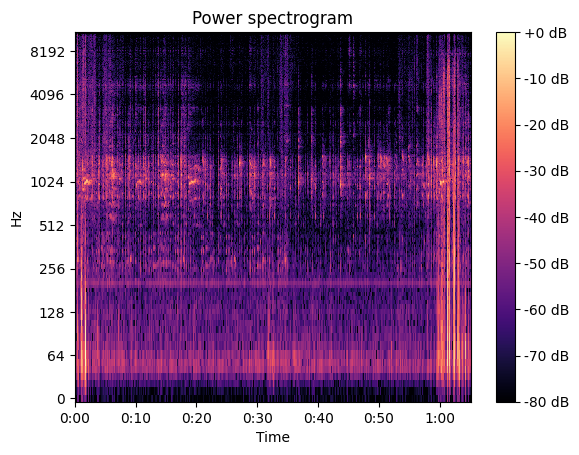

In [12]:
# visual widma
S_left = librosa.stft(audio, center=False)
D_short = librosa.stft(audio, hop_length=64)

fig, ax = plt.subplots()

img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram,ref=np.max), y_axis='log', x_axis='time', ax=ax)

ax.set_title('Power spectrogram')

fig.colorbar(img, ax=ax, format="%+2.0f dB");

##### 4) inne możliwości Chromagram

In [13]:
# Chromagram
chromagram = librosa.feature.chroma_stft(y=audio, sr=sr)
chromagram

array([[0.29769942, 0.11133622, 0.28401002, ..., 0.14379245, 0.12432596,
        0.18312024],
       [0.5797001 , 0.39867628, 0.52414745, ..., 1.        , 1.        ,
        1.        ],
       [0.56468844, 0.16186832, 0.17767337, ..., 0.8542338 , 0.8860371 ,
        0.791277  ],
       ...,
       [0.12475249, 0.06399111, 0.1381136 , ..., 0.06839755, 0.06495519,
        0.1367805 ],
       [0.13675535, 0.04263819, 0.10342907, ..., 0.04376675, 0.04680248,
        0.08548133],
       [0.22149143, 0.05213914, 0.30370706, ..., 0.03825454, 0.04585934,
        0.07637314]], dtype=float32)

In [14]:
chromagram.shape

(12, 2809)

##### 5) Tempo i metrum

In [15]:
tempo, beat_frames = librosa.beat.beat_track(y=audio, sr=sr)
tempo

112.34714673913044

In [16]:
beat_frames

array([   4,   31,   55,   77,  103,  128,  152,  175,  198,  221,  244,
        269,  292,  314,  338,  361,  384,  406,  430,  454,  478,  501,
        524,  548,  571,  594,  617,  642,  665,  688,  711,  735,  757,
        779,  802,  824,  846,  866,  886,  907,  928,  951,  973,  996,
       1018, 1040, 1062, 1084, 1106, 1129, 1153, 1176, 1199, 1223, 1245,
       1268, 1291, 1314, 1336, 1359, 1381, 1403, 1426, 1449, 1471, 1493,
       1516, 1539, 1561, 1584, 1606, 1628, 1650, 1674, 1695, 1717, 1739,
       1761, 1786, 1811, 1833, 1858, 1882, 1904, 1926, 1947, 1969, 1991,
       2013, 2034, 2056, 2078, 2100, 2122, 2144, 2166, 2187, 2209, 2231,
       2254, 2276, 2298, 2321, 2345, 2368, 2388, 2410, 2432, 2455, 2481,
       2504, 2525, 2547, 2568, 2592, 2615, 2638, 2659, 2680, 2707])

##### 6) Cechy tonalne

In [17]:
# Cechy tonalne
tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
brightness = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
tonnetz

array([[ 4.37949813e-02,  7.53634846e-03, -5.93657837e-02, ...,
         5.45446912e-02,  4.74103463e-02,  5.23868348e-02],
       [-1.69082950e-02, -1.83976627e-02, -3.94506541e-02, ...,
         3.59208754e-02,  4.47171036e-02,  6.27655349e-02],
       [ 5.56511506e-02,  3.60943414e-02,  5.56855239e-02, ...,
        -3.45097519e-02, -3.61284465e-02,  3.51294875e-06],
       [ 4.54354770e-02,  4.00482900e-02,  6.29143752e-02, ...,
         1.88103765e-02,  1.13972314e-02,  1.00316778e-02],
       [ 1.96559300e-02,  4.20723547e-03,  3.98063714e-03, ...,
         1.22558913e-02,  1.21791110e-02,  2.29878533e-02],
       [-1.17394747e-02, -1.48145603e-02,  1.24552259e-02, ...,
        -2.68543521e-02, -3.02511798e-02, -2.40574852e-02]])

In [18]:
brightness

array([[2313.03257818, 2173.46163847, 2119.98219941, ..., 2308.84369611,
        2390.70221751, 2514.89489776]])

###### 7) Mel-frequency cepstral coefficients (MFCC)

In [19]:
mfcc = librosa.feature.mfcc(y=audio, sr=sr)
mfcc

array([[-7.10231750e+02, -5.84954407e+02, -4.96515961e+02, ...,
        -5.80217407e+02, -5.88199951e+02, -6.11933350e+02],
       [ 8.04059982e+00,  8.67905350e+01,  1.06896767e+02, ...,
         1.04762405e+02,  1.01355064e+02,  9.22690735e+01],
       [-7.25920010e+00, -2.98647728e+01, -3.32504120e+01, ...,
        -2.02256927e+01, -1.75566616e+01, -3.83384204e+00],
       ...,
       [ 1.77140415e-01, -2.81203818e+00, -8.66141796e+00, ...,
         1.81700253e+00,  1.42905712e-02,  2.69129324e+00],
       [ 6.97578192e-01,  4.35430717e+00,  1.09334011e+01, ...,
         4.64260578e-01,  3.47569513e+00,  3.43305969e+00],
       [ 1.57942486e+00,  8.46333683e-01,  4.78330803e+00, ...,
         4.69175673e+00,  9.64083767e+00,  5.46971798e+00]], dtype=float32)

###### 8) data utworzenia pliku - przesłania pliku + nazwa pliku 

In [20]:
def get_file_creation_time(file_path):
    creation_timestamp = os.path.getctime(file_path)
    creation_datetime = datetime.datetime.fromtimestamp(creation_timestamp)
    return creation_datetime


file_path = 'output2.wav'

creation_time = get_file_creation_time(file_path)
nazwa_pliku = os.path.basename(file_path)

creation_time

datetime.datetime(2023, 6, 2, 7, 18, 21, 171074)

In [21]:
nazwa_pliku

'output2.wav'

### SCIPY + Librosa
##### 9) parametry Beranka (Equivalent Noise Level ENL, (Evening Noise Level, Night Noise Level - Lnight, Noise Burden Index, NBI)

In [22]:
# Obliczenie wartości RMS (Root Mean Square)
rms = np.sqrt(np.mean(audio**2))

# Obliczenie wartości ENL (Equivalent Noise Level)
enl = 10 * np.log10(rms**2)

# Obliczenie wartości Lnight (Evening Noise Level)
lnight = 10 * np.log10(np.percentile(np.abs(audio), 10)**2)

# Obliczenie wartości NBI (Noise Burden Index)
nbi = stats.kurtosis(np.abs(audio))

# Wyświetlenie wyników
print("Equivalent Noise Level (ENL):", enl)
print("Evening Noise Level (Lnight):", lnight)
print("Noise Burden Index (NBI):", nbi)

Equivalent Noise Level (ENL): -45.03353169890986
Evening Noise Level (Lnight): -77.64636119873158
Noise Burden Index (NBI): 1077.2117395227965


### Pandas & Python - cały prgram
- zebranie zmiennych dotychczasowej analizy dzwięku pliku w dataframe
- przegląda cały katalog w pętli gdzie wpadają pliki przetwarza i dodaje kolejne pliki jako rządy dataframe df
- brakuje danych o lokalizacji, wieku uczestnika itd, ale są to kolejne zmienne jako kolumny df 

In [23]:
import os
import subprocess
import datetime
import librosa
import numpy as np
import pandas as pd
from scipy import stats

ffmpeg_path = 'C:\\FFmpeg\\bin\\ffmpeg.exe'
input_directory = 'tunes'
output_directory = 'converted'

# Tworzenie katalogu na przekonwertowane pliki, jeśli nie istnieje
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Przetwarzanie plików m4a w katalogu
features = []
for file_name in os.listdir(input_directory):
    if file_name.endswith('.m4a'):
        input_file = os.path.join(input_directory, file_name)
        output_file = os.path.join(output_directory, os.path.splitext(file_name)[0] + '.wav')
        subprocess.run([ffmpeg_path, '-i', input_file, output_file])

        # Pobieranie czasu utworzenia pliku
        creation_timestamp = os.path.getctime(output_file)
        creation_datetime = datetime.datetime.fromtimestamp(creation_timestamp)
        
        # Wczytywanie audio za pomocą biblioteki librosa
        audio, sr = librosa.load(output_file)
        
        # Obliczanie cech audio
        peak_level = np.max(np.abs(audio))
        peak_level_db = 20 * np.log10(peak_level)
        leq = np.mean(librosa.amplitude_to_db(np.abs(audio)))
        spectrogram = np.abs(librosa.stft(audio))
        spectrogram_db = librosa.amplitude_to_db(spectrogram)
        chromagram = librosa.feature.chroma_stft(y=audio, sr=sr)
        tempo, beat_frames = librosa.beat.beat_track(y=audio, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
        brightness = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr)
        rms = np.sqrt(np.mean(audio**2))
        enl = 10 * np.log10(rms**2)
        lnight = 10 * np.log10(np.percentile(np.abs(audio), 10)**2)
        nbi = stats.kurtosis(np.abs(audio))
        
        # Dodawanie cech do listy
        features.append({'nazwa_pliku': file_name, 'creation_time': creation_datetime, 'peak_level': peak_level, 
                         'peak_level_db': peak_level_db, 'leq': leq, 'tempo' : tempo, 'enl':enl, 'lnight':lnight, 
                         'nbi':nbi, 'spectrogram' : spectrogram,'spectrogram_db': spectrogram_db, 
                         'chromagram': chromagram, 'mfcc': mfcc, 'beat_frames': beat_frames, 'tonnetz': tonnetz})

# Tworzenie dataframe df
df = pd.DataFrame(features)
df

,nazwa_pliku,creation_time,peak_level,peak_level_db,leq,tempo,enl,lnight,nbi,spectrogram,spectrogram_db,chromagram,mfcc,beat_frames,tonnetz
0,t1.m4a,2023-06-02 09:25:30.058462,0.669196,-3.488939,-55.353863,151.999081,-40.349339,-69.473145,746.171883,"[[0.0046727466, 0.036826156, 0.044991467, 0.01...","[[-42.462734, -28.676872, -26.937397, -34.2766...","[[0.62577254, 0.47000417, 0.5177605, 0.5720022...","[[-602.69226, -528.948, -473.25366, -462.1403,...","[4, 23, 41, 61, 80, 97, 113, 130, 147, 164, 18...","[[-0.04442286046934837, -0.04684174047848145, ..."
1,t2.m4a,2023-06-02 09:25:31.169278,0.778806,-2.171412,-61.181831,112.347147,-45.033532,-77.646361,1077.211740,"[[4.9651964e-05, 0.00072789536, 0.0024662835, ...","[[-52.81997, -52.81997, -52.15914, -52.81997, ...","[[0.29769942, 0.111336224, 0.28401002, 0.96182...","[[-710.23175, -584.9544, -496.51596, -451.1967...","[4, 31, 55, 77, 103, 128, 152, 175, 198, 221, ...","[[0.043794981332896964, 0.007536348462989687, ..."


### Inne

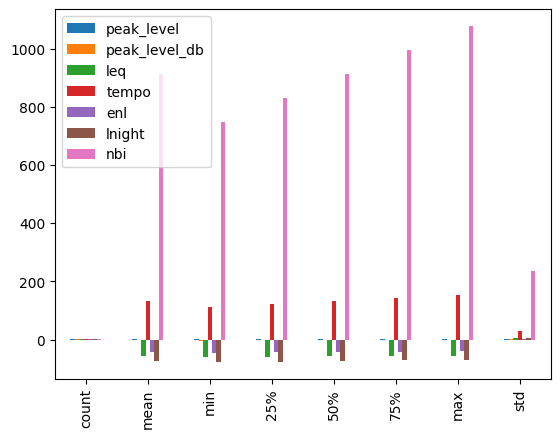

In [24]:
df.describe().plot(kind = 'bar');

##### Amplituda w czasie ?

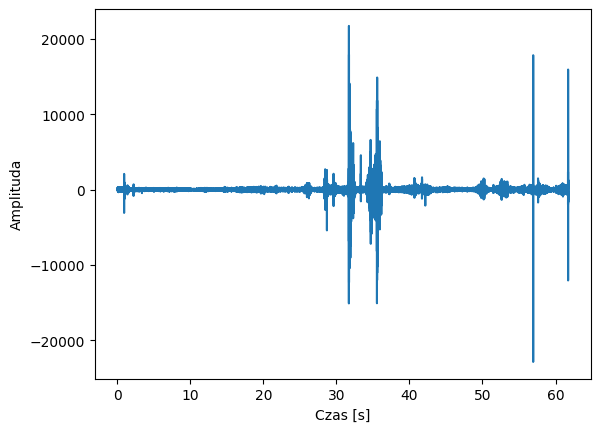

In [25]:
sample_rate, audio_data = wavfile.read('converted/t1.wav')

audio_df = pd.DataFrame(audio_data, columns=['Amplituda'])
audio_df['Czas'] = audio_df.index / sample_rate

plt.plot(audio_df['Czas'], audio_df['Amplituda'])
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.show()

In [26]:
average_amplitude = audio_df['Amplituda'].mean()
print('Średnia amplituda ?:', average_amplitude)

Średnia amplituda ?: -0.07909201356242948


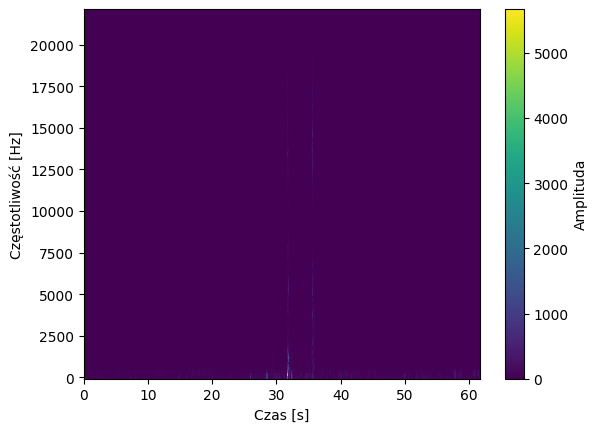

In [27]:
frequencies, times, spectrogram = scipy.signal.stft(audio_data, sample_rate)

# Wyświetl spektrogram
plt.pcolormesh(times, frequencies, np.abs(spectrogram))
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')
plt.colorbar(label='Amplituda')
plt.show()

### Machine learning & Librosa wywiad z gpt
Za pomocą biblioteki Librosa i technik uczenia maszynowego można osiągnąć wiele w zakresie analizy i przetwarzania dźwięku. Oto kilka przykładów zastosowań Librosa w połączeniu z technikami uczenia maszynowego:

- Klasyfikacja dźwięków: Można wykorzystać Librosa do ekstrakcji cech dźwiękowych z plików audio, takich jak mel-spectrogramy, chromagramy, czy MFCC (Mel-frequency cepstral coefficients). Następnie te cechy można wykorzystać jako wejście do modelu uczenia maszynowego, aby trenować klasyfikator, który rozpoznaje różne dźwięki lub instrumenty muzyczne.

-  Wykrywanie emocji w głosie: Librosa może być wykorzystana do ekstrakcji cech akustycznych z plików audio, takich jak tonalność, intensywność czy tempo. Te cechy można następnie wykorzystać jako dane wejściowe do modelu uczenia maszynowego, aby trenować klasyfikator, który rozpoznaje emocje w głosie, takie jak radość, smutek, złość itp.

-  Transkrypcja muzyczna: Librosa oferuje narzędzia do ekstrakcji melodiicznych linii w plikach audio. Można wykorzystać te narzędzia do transkrypcji muzycznej, czyli konwersji nagrań audio na notację muzyczną. Można na przykład trenować modele uczenia maszynowego do identyfikacji wysokości dźwięków i wykonywania transkrypcji melodii.

- Wyszukiwanie dźwięków: Librosa można również wykorzystać do tworzenia systemów wyszukiwania dźwięków. Można wyekstrahować cechy dźwiękowe z dużego zbioru plików audio i zbudować model uczenia maszynowego, który indeksuje te cechy, umożliwiając późniejsze wyszukiwanie podobnych dźwięków w czasie rzeczywistym.

-  Generowanie dźwięków: Librosa może być wykorzystana do generowania nowych dźwięków. Można na przykład trenować modele generatywne, takie jak generatywne modele adversarialne (GANs) lub autoregresyjne modele, które na podstawie danych audio uczą się generować nowe dźwięki, jak np. syntetyczne melodie czy dźwięki instrumentów.

- Warto podkreślić, że Librosa oferuje różnorodne narzędzia do ekstrakcji cech dźwiękowych i analizy sygnałów audio, które można wykorzystać jako wejście dla modeli uczenia maszynowego. Sukces w konkretnych zadaniach zależy również od odpowiedniego dostosowania i trenowania modeli uczenia maszynowego w zależności od specyfiki